In [24]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils, financial_utils, time_series_utils

In [25]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [3]:
query = """
    select *
    from td.options_view
    where symbol = 'BA'
    """

options = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)

In [3]:
options.head(1).T

,0
symbol,BA
volatility,29
n_contracts,1782
interest_rate,2.42788
put_call,PUT
description,BA Jan 17 2020 540 Put
exchange_name,OPR
bid,155.25
ask,156.3
last,206.05


### Black scholes

In [40]:
option = financial_utils.BlackScholes(
    current_stock_price=380,
    strike_price=385,
    risk_free_rate=1.025,
    days_to_maturity=160,
    volatility=1.15,
    call_put='call'
)

In [38]:
print('Theoretical option price: $' + str(round(option.option_price, 2)))

Theoretical option price: $14.64


### Greeks

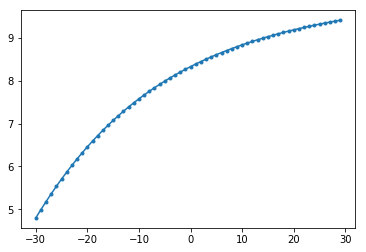

In [43]:
deltas = option.get_greek(greek='delta', steps=30)
plt.plot(deltas, marker='.')
plt.show()

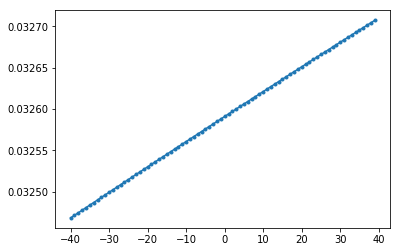

In [44]:
ros = option.get_greek(greek='ro', steps=40)
plt.plot(ros, marker='.')
plt.show()

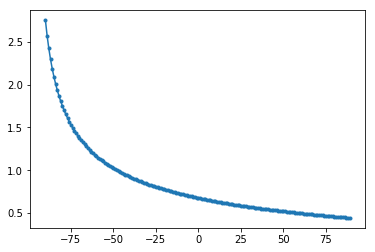

In [42]:
thetas = option.get_greek('theta', steps=90)
plt.plot(thetas, marker='.')
plt.show()

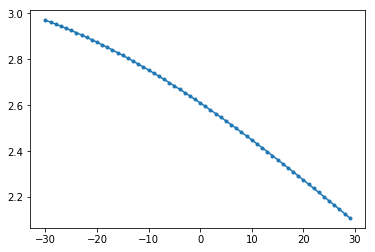

In [41]:
vegas = option.get_greek(greek='vega', steps=30)
plt.plot(vegas, marker='.')
plt.show()

### Implied volatility

In [6]:
imp_vols = []
current_stock_price = 354.42
risk_free_rate=1.025
volatility=.5
opts = options[(options['days_to_expiration']==120) 
               & (options['put_call'].str.lower()=='call') 
               & (options['total_volume']>0)]
for idw, row in opts.iterrows():
    imp_vol = financial_utils.BlackScholes(
        current_option_price=row['close_price'],
        current_stock_price=current_stock_price,
        strike_price=row['strike'],
        risk_free_rate=risk_free_rate,
        days_to_maturity=row['days_to_expiration_date'],
        volatility=volatility,
        call_put=row['put_call'].lower()
    ).implied_volatility
    imp_vols.append(imp_vol)

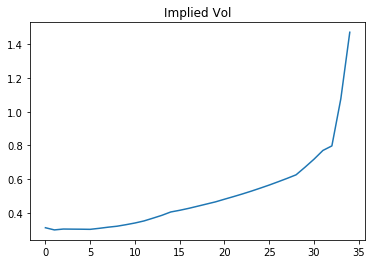

In [16]:
imp_vols = pd.DataFrame(imp_vols)
plt.figure()
plt.title('Implied Vol')
plt.plot(imp_vols)
plt.show()

In [9]:
df = options[(options['file_datetime'].dt.date == options['file_datetime'].min().date())
             & (options['total_volume'] > 0)
             & (options['put_call'].str.lower() == 'call')
             & (options['strike'].between(200, 500))
             & (options['days_to_expiration_date'].between(10, 300))
            ].copy()

In [22]:
current_stock_price = 380
df['implied_volatility'] = df.apply(lambda option: 
                                    financial_utils.BlackScholes(current_option_price=option['close_price'],
                                                                 current_stock_price=current_stock_price,
                                                                 strike_price=option['strike'],
                                                                 risk_free_rate=risk_free_rate,
                                                                 days_to_maturity=option['days_to_expiration_date'],
                                                                 call_put=option['put_call'].lower()
                                                                ).implied_volatility,
                                    axis=1)
df = df.sort_values(by='implied_volatility').iloc[5:-5]

<IPython.core.display.Javascript object>


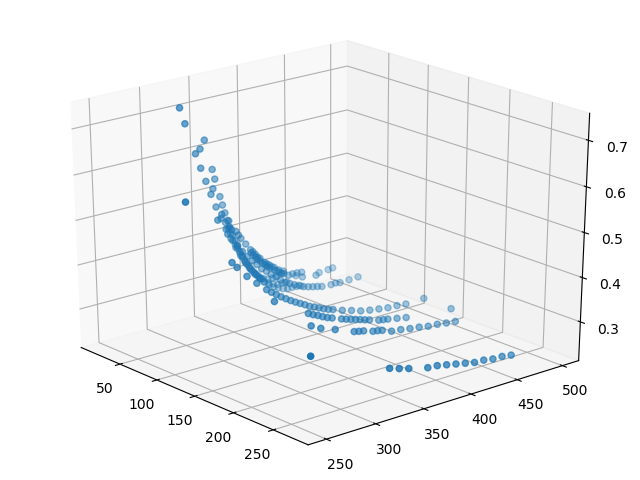

In [21]:
fig = plt.figure()
ax = Axes3D(fig)

zline = df['implied_volatility']
xline = df['days_to_expiration_date']
yline = df['strike']

ax.scatter(xline, yline, zline, 'gray')